In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy

from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv('/Users/Emily/Desktop/ReviewerResponses/delta_delta.csv', index_col=0, header=1)
data = data.iloc[1:]
data.columns = data.columns.str.replace('Unnamed.*', 'Strain')

data.tail()

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,bca_high,bca_low,control,difference,test,Strain
0,,,,,,
37,6.849777,3.095476,DMSO,4.988027,Spinosad,PR678
38,-4.802221,-8.857336,DMSO,-6.835087,Thiophene,PR678
39,7.797987,3.811547,DMSO,5.826407,Ursolic acid,PR678
40,-1.120939,-4.845255,DMSO,-2.988930,p-Tolualdehyde,PR678
41,-0.740827,-4.736980,DMSO,-2.724380,α-Phellandrene,PR678


In [3]:
N2dat = pd.read_csv('C:/Users/Emily/Documents/S1/inner3.csv', index_col=0)
N2dat = N2dat.sort_values(by='difference')
comp_ord = list(N2dat['test'].unique())
comp_ord.remove('DMSO')
comp_ord.remove('Safranal')

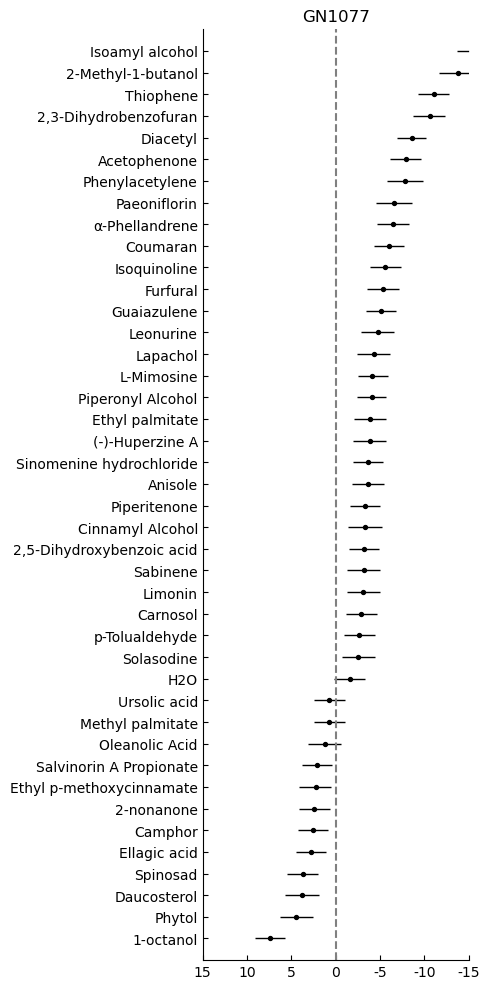

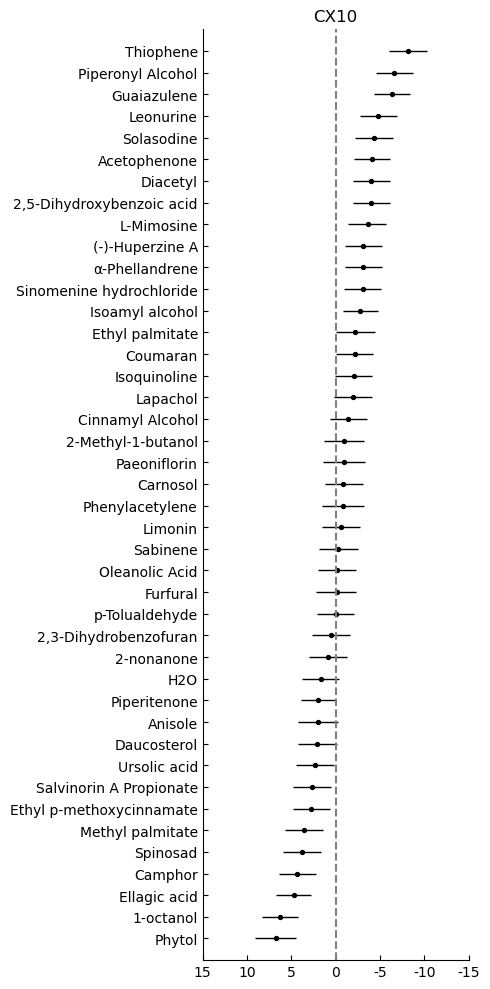

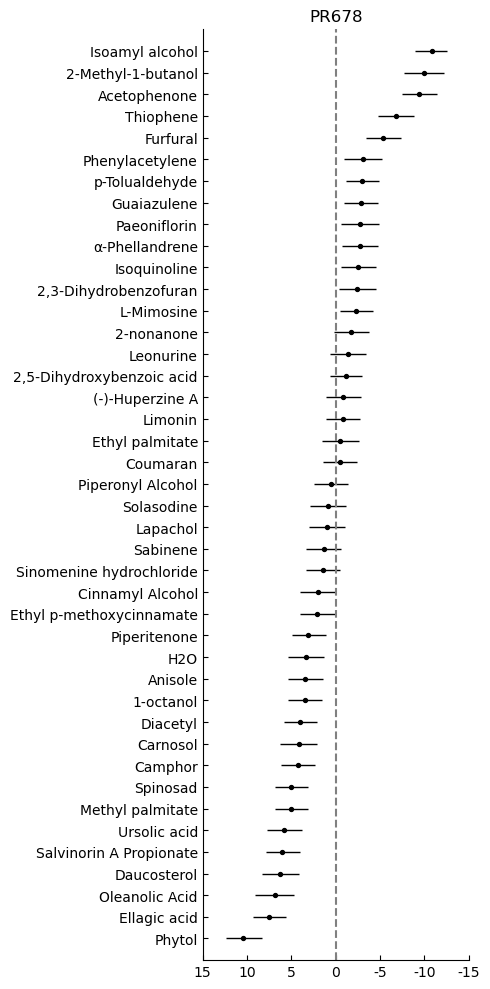

In [4]:
strains = ['GN1077', 'CX10', 'PR678']

reordered_comps = pd.DataFrame()


for s in strains:
    fig, ax = plt.subplots(figsize=(5, 10)) 
    hold = data.loc[data['Strain'] == s]
    
    reordered = hold.sort_values(by='difference', ascending=False)
    
    ordr = list(reordered['test'])
    reordered_comps[s] = ordr
    
    #reordered = hold.set_index('test')
    #reordered = reordered.reindex(comord)
    reordered = reordered.reset_index()
    reordered['bca_low'] = reordered['bca_low'].astype(np.float64)
    reordered['bca_high'] = reordered['bca_high'].astype(np.float64)
    positions = list(range(0, len(ordr)))
    
    lines1 = []

    
    for index, row in reordered.iterrows():
        

        line = ((row['bca_low'], index), (row['bca_high'], index))
        lines1.append(line)


        #ax.fill_betweenx(positions, plot_data['bca_low'], plot_data['bca_high'], alpha=.25)
    ytick_labels = list(reordered['test'])
    mdiffs1 = list(reordered['difference'])

    hln_coll1 = mpl.collections.LineCollection(lines1, colors='black', linewidths = 1)

    #ax[r,c] = plt.gca()



    x_positions = list(np.arange(-15, 20, 5))

    plt.yticks(positions, ytick_labels )
    plt.xticks(x_positions, x_positions)


    #ax[r,c].xaxis.set_ticks_position('both')
    ax.add_collection(hln_coll1)
    ax.scatter(mdiffs1, positions, s=8, c='black')
    ax.tick_params(axis='both', tickdir='in')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(15, -15)    
    ax.set_ylim(-1, len(ordr))
    ax.set_title(s)
    ax.axvline(0, ls='--', c='gray')
    plt.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
 
    #plt.savefig('C:/Users/Emily/Desktop/ReviewerResponses/' + s + '_dd_sorted.svg')
plt.show()

In [7]:
def clean_df(fpath):
    d = pd.read_csv(fpath, index_col=0, header=1)
    d = d.iloc[1:]
    d.columns = d.columns.str.replace('Unnamed.*', 'Strain')
    return d


In [21]:
vGN = clean_df('/Users/Emily/Desktop/ReviewerResponses/singleGN_dd.csv')
vGN.head()

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,bca_high,bca_low,control,difference,test,Strain
0,,,,,,
0,-1.283171,-4.772431,DMSO,-2.941214,(-)-Huperzine A,PR678
1,5.513259,2.371091,DMSO,3.912354,1-octanol,PR678
2,-6.539367,-9.945643,DMSO,-8.215649,"2,3-Dihydrobenzofuran",PR678
3,-0.520134,-3.459255,DMSO,-2.014649,"2,5-Dihydroxybenzoic acid",PR678
4,-1.911097,-5.711808,DMSO,-3.812671,2-Methyl-1-butanol,PR678


In [22]:
cxgn = vGN.loc[(vGN['Strain']=='CX10') & (vGN['bca_low']<0)& (vGN['bca_high']>0)]
cxgn.sort_values(by='difference')

prgn = vGN.loc[(vGN['Strain']=='PR678') & (vGN['bca_low']<0)& (vGN['bca_high']>0)]
prgn.sort_values(by='difference')

,bca_high,bca_low,control,difference,test,Strain
0,,,,,,
8,0.008540,-3.367016,DMSO,-1.725395,Camphor,PR678
37,0.307826,-2.824307,DMSO,-1.270536,Spinosad,PR678
17,1.673924,-1.544983,DMSO,0.020029,Furfural,PR678
15,1.683890,-1.374347,DMSO,0.183840,Ethyl p-methoxycinnamate,PR678
40,1.777222,-1.160938,DMSO,0.321815,p-Tolualdehyde,PR678
6,3.047179,-0.111032,DMSO,1.492482,Acetophenone,PR678


0            2-Methyl-1-butanol
1               Isoamyl alcohol
2         2,3-Dihydrobenzofuran
3               Phenylacetylene
4                  Paeoniflorin
5                       Anisole
6                  Piperitenone
7                      Furfural
8                      Diacetyl
9                      Coumaran
10                 Acetophenone
11                 Isoquinoline
12               α-Phellandrene
13                          H2O
14                     Sabinene
15                    Thiophene
16             Methyl palmitate
17               p-Tolualdehyde
18                      Limonin
19                       Phytol
20                     Lapachol
21                     Carnosol
22                 Ellagic acid
23             Cinnamyl Alcohol
24                      Camphor
25              Ethyl palmitate
26                 Ursolic acid
27              (-)-Huperzine A
28     Sinomenine hydrochloride
29      Salvinorin A Propionate
30                   L-Mimosine
31     E

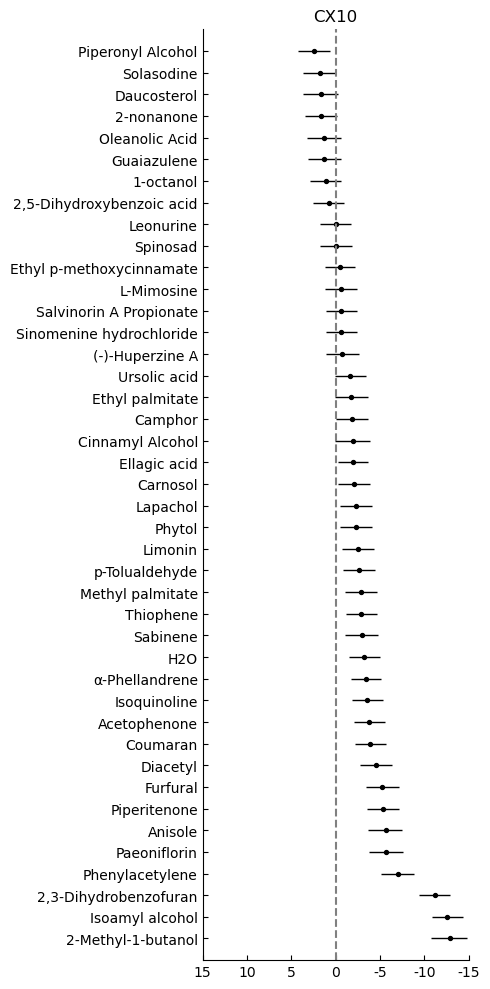

0                      Diacetyl
1         2,3-Dihydrobenzofuran
2                      Carnosol
3                       Anisole
4                  Piperitenone
5                        Phytol
6                Oleanolic Acid
7                      Coumaran
8              Cinnamyl Alcohol
9                      Lapachol
10     Sinomenine hydrochloride
11                 Ursolic acid
12                          H2O
13                 Ellagic acid
14              Phenylacetylene
15            Piperonyl Alcohol
16                     Sabinene
17              Isoamyl alcohol
18             Methyl palmitate
19                    Thiophene
20      Salvinorin A Propionate
21           2-Methyl-1-butanol
22                 Paeoniflorin
23               α-Phellandrene
24                   Solasodine
25              Ethyl palmitate
26                    Leonurine
27                 Isoquinoline
28              (-)-Huperzine A
29                  Daucosterol
30                      Limonin
31      

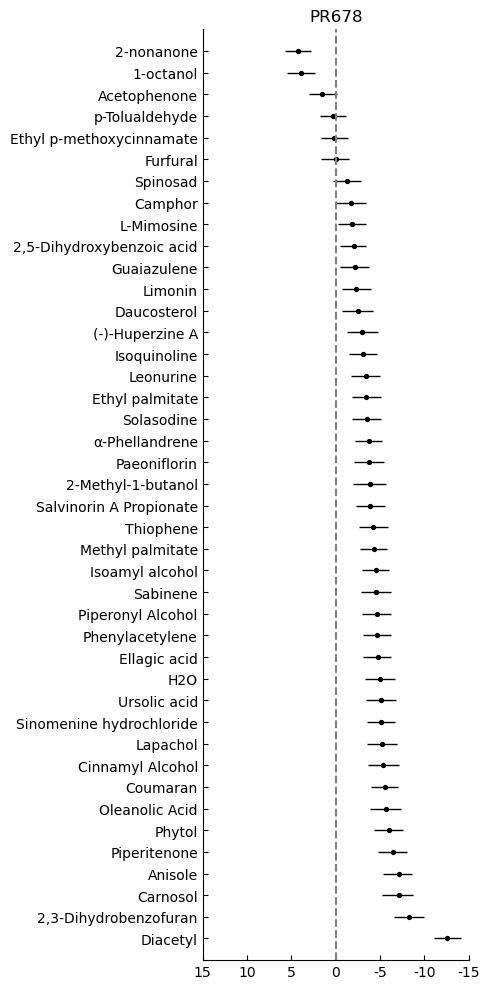

In [34]:
strains = ['CX10', 'PR678']


for s in strains:
    fig, ax = plt.subplots(figsize=(5, 10)) 
    hold = vGN.loc[vGN['Strain'] == s]
    
    #sorter = list(reordered_comps[s])
    #sorterIndex = dict(zip(sorter, range(len(sorter))))
    #hold['Test'] = hold['test'].map(sorterIndex)
    
    
    hold.sort_values(['difference'],
        ascending = True, inplace = True, ignore_index = True)
    ordr = hold['test']
    print(ordr)
    reordered = hold.set_index('test')
    reordered = reordered.reindex(ordr, index=index)
    reordered = reordered.reset_index()
    #reordered = hold
    reordered['bca_low'] = reordered['bca_low'].astype(np.float64)
    reordered['bca_high'] = reordered['bca_high'].astype(np.float64)
    positions = list(range(0, len(sorter)))
    
    lines1 = []

    
    for index, row in reordered.iterrows():
        

        line = ((row['bca_low'], index), (row['bca_high'], index))
        lines1.append(line)


        #ax.fill_betweenx(positions, plot_data['bca_low'], plot_data['bca_high'], alpha=.25)
    ytick_labels = list(reordered['test'])
    mdiffs1 = list(reordered['difference'])

    hln_coll1 = mpl.collections.LineCollection(lines1, colors='black', linewidths = 1)

    #ax[r,c] = plt.gca()



    x_positions = list(np.arange(-15, 20, 5))

    plt.yticks(positions, ytick_labels )
    plt.xticks(x_positions, x_positions)


    #ax[r,c].xaxis.set_ticks_position('both')
    ax.add_collection(hln_coll1)
    ax.scatter(mdiffs1, positions, s=8, c='black')
    ax.tick_params(axis='both', tickdir='in')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(15, -15)    
    ax.set_ylim(-1, len(sorter))
    ax.set_title(s)
    ax.axvline(0, ls='--', c='gray')
    plt.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
 
    plt.savefig('C:/Users/Emily/Desktop/ReviewerResponses/' + s + 'vGN_dd_sorted_ALT.svg')
    plt.show()

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


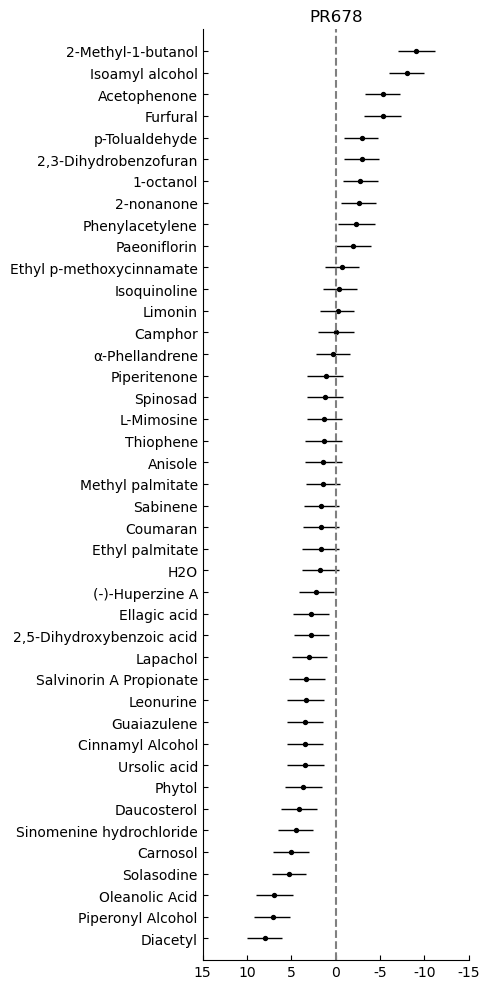

In [14]:
strains = ['PR678']

cxpr = clean_df('/Users/Emily/Desktop/ReviewerResponses/ddSingles.csv')


for s in strains:
    fig, ax = plt.subplots(figsize=(5, 10)) 
    hold = cxpr.loc[cxpr['Strain'] == s]
    
    reordered = hold.sort_values(by='difference', ascending=False)
    ordr = list(reordered['test'])
    
    #reordered = hold.set_index('test')
    #reordered = reordered.reindex(comord)
    reordered = reordered.reset_index()
    reordered['bca_low'] = reordered['bca_low'].astype(np.float64)
    reordered['bca_high'] = reordered['bca_high'].astype(np.float64)
    positions = list(range(0, len(ordr)))
    
    lines1 = []

    
    for index, row in reordered.iterrows():
        

        line = ((row['bca_low'], index), (row['bca_high'], index))
        lines1.append(line)


        #ax.fill_betweenx(positions, plot_data['bca_low'], plot_data['bca_high'], alpha=.25)
    ytick_labels = list(reordered['test'])
    mdiffs1 = list(reordered['difference'])

    hln_coll1 = mpl.collections.LineCollection(lines1, colors='black', linewidths = 1)

    #ax[r,c] = plt.gca()



    x_positions = list(np.arange(-15, 20, 5))

    plt.yticks(positions, ytick_labels )
    plt.xticks(x_positions, x_positions)


    #ax[r,c].xaxis.set_ticks_position('both')
    ax.add_collection(hln_coll1)
    ax.scatter(mdiffs1, positions, s=8, c='black')
    ax.tick_params(axis='both', tickdir='in')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(15, -15)    
    ax.set_ylim(-1, len(ordr))
    ax.set_title(s)
    ax.axvline(0, ls='--', c='gray')
    plt.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
 
    #plt.savefig('C:/Users/Emily/Desktop/ReviewerResponses/' + s + 'singles_dd_sorted.svg')
plt.show()

In [19]:
cxpr.tail()

,bca_high,bca_low,control,difference,test,Strain
0,,,,,,
37,3.237250,-0.799230,DMSO,1.197632,Spinosad,PR678
38,3.438217,-0.664545,DMSO,1.359596,Thiophene,PR678
39,5.499494,1.354726,DMSO,3.484959,Ursolic acid,PR678
40,-0.907832,-4.820265,DMSO,-2.952557,p-Tolualdehyde,PR678
41,2.268052,-1.585999,DMSO,0.343179,α-Phellandrene,PR678


In [17]:
cxminpr = cxpr.loc[(cxpr['bca_low']<0)& (cxpr['bca_high']>0)]
cxminpr.sort_values(by='difference')

,bca_high,bca_low,control,difference,test,Strain
0,,,,,,
28,0.135219,-3.982169,DMSO,-1.906342,Paeoniflorin,PR678
15,1.155544,-2.570670,DMSO,-0.717384,Ethyl p-methoxycinnamate,PR678
21,1.458237,-2.387517,DMSO,-0.420339,Isoquinoline,PR678
25,1.765851,-2.115297,DMSO,-0.205439,Limonin,PR678
8,1.969748,-2.101402,DMSO,-0.056612,Camphor,PR678
41,2.268052,-1.585999,DMSO,0.343179,α-Phellandrene,PR678
31,3.188545,-0.810207,DMSO,1.145236,Piperitenone,PR678
37,3.237250,-0.799230,DMSO,1.197632,Spinosad,PR678
22,3.221200,-0.761483,DMSO,1.270779,L-Mimosine,PR678


In [5]:
gn_nr = data.loc[(data['Strain'] == 'GN1077') & (data['bca_low'] < 0)& (data['bca_high'] > 0)]
cx_nr =  data.loc[(data['Strain'] == 'CX10') & (data['bca_low'] < 0)& (data['bca_high'] > 0)]
cx_nr = cx_nr.sort_values(by='difference')
pr_nr = data.loc[(data['Strain'] == 'PR678') & (data['bca_low'] < 0)& (data['bca_high'] > 0)]
pr_nr = pr_nr.sort_values(by='difference')


In [6]:
clstr_dat = data.drop(columns='control')
clstr_dat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 0 to 41
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bca_high    126 non-null    float64
 1   bca_low     126 non-null    float64
 2   difference  126 non-null    float64
 3   test        126 non-null    object 
 4   Strain      126 non-null    object 
dtypes: float64(3), object(2)
memory usage: 5.9+ KB


In [7]:
encoders={}
for col in clstr_dat.columns:
    series = clstr_dat[col]
    label_encoder = LabelEncoder()
    clstr_dat[col] = pd.Series(label_encoder.fit_transform(series[series.notnull()]),
    index = series[series.notnull()].index
                         )
    encoders[col] = label_encoder
    

In [8]:
for i in clstr_dat.columns:
    clstr_dat[i].astype(int)
for col in clstr_dat.columns:
    clstr_dat[col] = encoders[col].inverse_transform(clstr_dat[col])

In [9]:
clstr_dat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 0 to 41
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bca_high    126 non-null    float64
 1   bca_low     126 non-null    float64
 2   difference  126 non-null    float64
 3   test        126 non-null    object 
 4   Strain      126 non-null    object 
dtypes: float64(3), object(2)
memory usage: 5.9+ KB


In [72]:
catcolpos = [clstr_dat.columns.get_loc(col) for col in list(clstr_dat.select_dtypes('object').columns)]
print('Cat cols      : {}'.format(list(clstr_dat.select_dtypes('object').columns)))
print('Cat col pos       : {}'.format(catcolpos))

Cat cols      : ['test', 'Strain']
Cat col pos       : [3, 4]


In [73]:
clstr_Matrix = clstr_dat.to_numpy()

In [74]:
c = []

for cluster in range(1,10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(clstr_Matrix, categorical = catcolpos)
        print('Cluster initiation: {}'.format(cluster))
        c = c.append(kprototype.c_)
    except:
        break
        


Cluster initiation: 1


In [6]:
def CItoP(row):
    u = row['bca_high']
    l = row['bca_low']
    Est = row['difference']
    #calculate the standard error from the upper and lower bounds of the confidence interval
    SE = (u-l)/(2*1.96)
    #calculate the z-score from the difference in means (estimated mean) over the standard error
    z = Est/SE
    #find the area under the curve of the CDF for the associated z-score using scipy.stats.special.ndtr or scipy.stats.norm.sf
    #equations to integrate the area under the curve for both functions are the same.
    p = norm.sf(abs(z))*2 #two-sided
    return p

In [30]:
def BH_critical(i, m, Q):
    correction = (i/m)*Q
    return correction

In [31]:
def pranks(df, fdr):
    hed = 'BH_critical_' + str(fdr)
    for index, row in df.iterrows():
        df.loc[index, hed] = BH_critical(row['rank'],42,fdr)
    return df

In [32]:
ps = pd.DataFrame()
for s in strains:
    subs = data.loc[data['Strain']==s]
    for index, row in subs.iterrows():
        subs.loc[index, 'p_value'] = CItoP(row)
    ranked = subs.sort_values(by=['p_value']).reset_index(drop=True)
    ranks=np.arange(1,len(ranked)+1)
    ranked['rank'] = ranks
    BH = pranks(ranked, .05)
    ps = ps.append(BH)


C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [38]:
filtered_BH = ps.loc[ps['p_value'] < ps['BH_critical_0.05']]
print(len(filtered_BH))


87


In [41]:
filtered_BH.to_csv('/Users/Emily/Desktop/ReviewerResponses/filtered_ddBH.csv')

In [42]:
ps.to_csv('/Users/Emily/Desktop/ReviewerResponses/ddBH.csv')

In [19]:
both_decrease = data.loc[(data['Strain']=='PR678') | (data['Strain']=='CX10')&(data['bca_low'] < 0) & (data['bca_high'] < 0)]
both_increase = data.loc[((data['Strain']=='PR678') | (data['Strain']=='CX10'))&((data['bca_low'] > 0) & (data['bca_high'] > 0))]
both_increase
#both_increase = data.loc[(data['bca_low'] > 0) & (data['bca_high'] > 0)]
#one_increase_one_nc
#one_decrease_one_nc
#one_increase_one_decrease

,bca_high,bca_low,control,difference,test,Strain
0,,,,,,
1,8.333437,4.203025,DMSO,6.272903,1-octanol,CX10
8,6.359081,2.279861,DMSO,4.324269,Camphor,CX10
14,6.759832,2.734867,DMSO,4.738386,Ellagic acid,CX10
15,4.851578,0.684922,DMSO,2.776740,Ethyl p-methoxycinnamate,CX10
26,5.699451,1.487442,DMSO,3.565126,Methyl palmitate,CX10
30,9.073897,4.497570,DMSO,6.753860,Phytol,CX10
34,4.783115,0.552982,DMSO,2.684596,Salvinorin A Propionate,CX10
37,5.986385,1.710477,DMSO,3.790395,Spinosad,CX10
39,4.441538,0.149526,DMSO,2.341448,Ursolic acid,CX10
